# San Andreas Fault Velocity Profile - Bayesian Inversion

## Assignment Overview

This notebook performs a Bayesian inversion to estimate San Andreas Fault parameters from GPS velocity data across the Carrizo Plain section. The analysis combines geodetic observations with a simple elastic dislocation model to infer fault characteristics.

### Objectives

1. **Load and Visualize GPS Data**
   - Load GPS velocity measurements from `vel.NA.postseismic-corrected.txt`
   - Construct a velocity profile perpendicular to the San Andreas Fault across the Carrizo Plain
   - Visualize the spatial distribution of GPS stations and velocity field

2. **Forward Model**
   - Implement a screw dislocation model using the `fault_velocity_model` function
   - Model equation: $v = -\frac{s}{\pi} \arctan\left(\frac{x-x_f}{d}\right)$
   - Where:
     - $v$ = surface velocity (mm/yr)
     - $s$ = fault slip rate (mm/yr)
     - $x_f$ = fault position along profile (km)
     - $d$ = locking depth (km)
     - $x$ = position along profile (km)

3. **Bayesian Inversion (MCMC-Metropolis-Hastings)**
   - Estimate three key parameters:
     - **Locking depth** ($d$): Depth to which the fault is locked
     - **Fault position** ($x_f$): Location of the fault trace
     - **Slip rate** ($s$): Long-term fault slip rate
   - Use Metropolis-Hastings algorithm to sample the posterior distribution
   - Assume Gaussian likelihood for the misfit between model and data

4. **Analysis and Visualization**
   - **Joint Posterior Distributions**: Create scatter plots and contour plots showing correlations between parameters
   - **Marginal Distributions**: Plot histograms for each individual parameter
   - **Model Fit**: Compare best-fit model predictions with observed GPS velocities
   - **Uncertainty Quantification**: Estimate parameter uncertainties from posterior distributions

### Physical Context

The San Andreas Fault is a major strike-slip fault system. In the shallow crust (0 to locking depth $d$), the fault is locked and accumulates elastic strain. Below the locking depth, the fault creeps steadily at the long-term slip rate $s$. GPS stations measure the surface velocity field resulting from this deep slip on a locked fault, which follows an arctangent profile in the elastic half-space approximation.

### Expected Outcomes

- Locking depth: ~10-20 km (typical for continental strike-slip faults)
- Slip rate: ~30-40 mm/yr (consistent with geologic estimates for the Carrizo Plain section)
- Fault position: Should align with the mapped San Andreas Fault trace
- Well-constrained posterior distributions with realistic uncertainties

Loaded 3035 GPS stations
Longitude range: [-125.00, -101.09]
Latitude range: [28.45, 50.20]
Ve range: [-37.54, 13.02] mm/yr
Vn range: [-0.25, 38.67] mm/yr


/Users/kajjohns/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/kajjohns/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


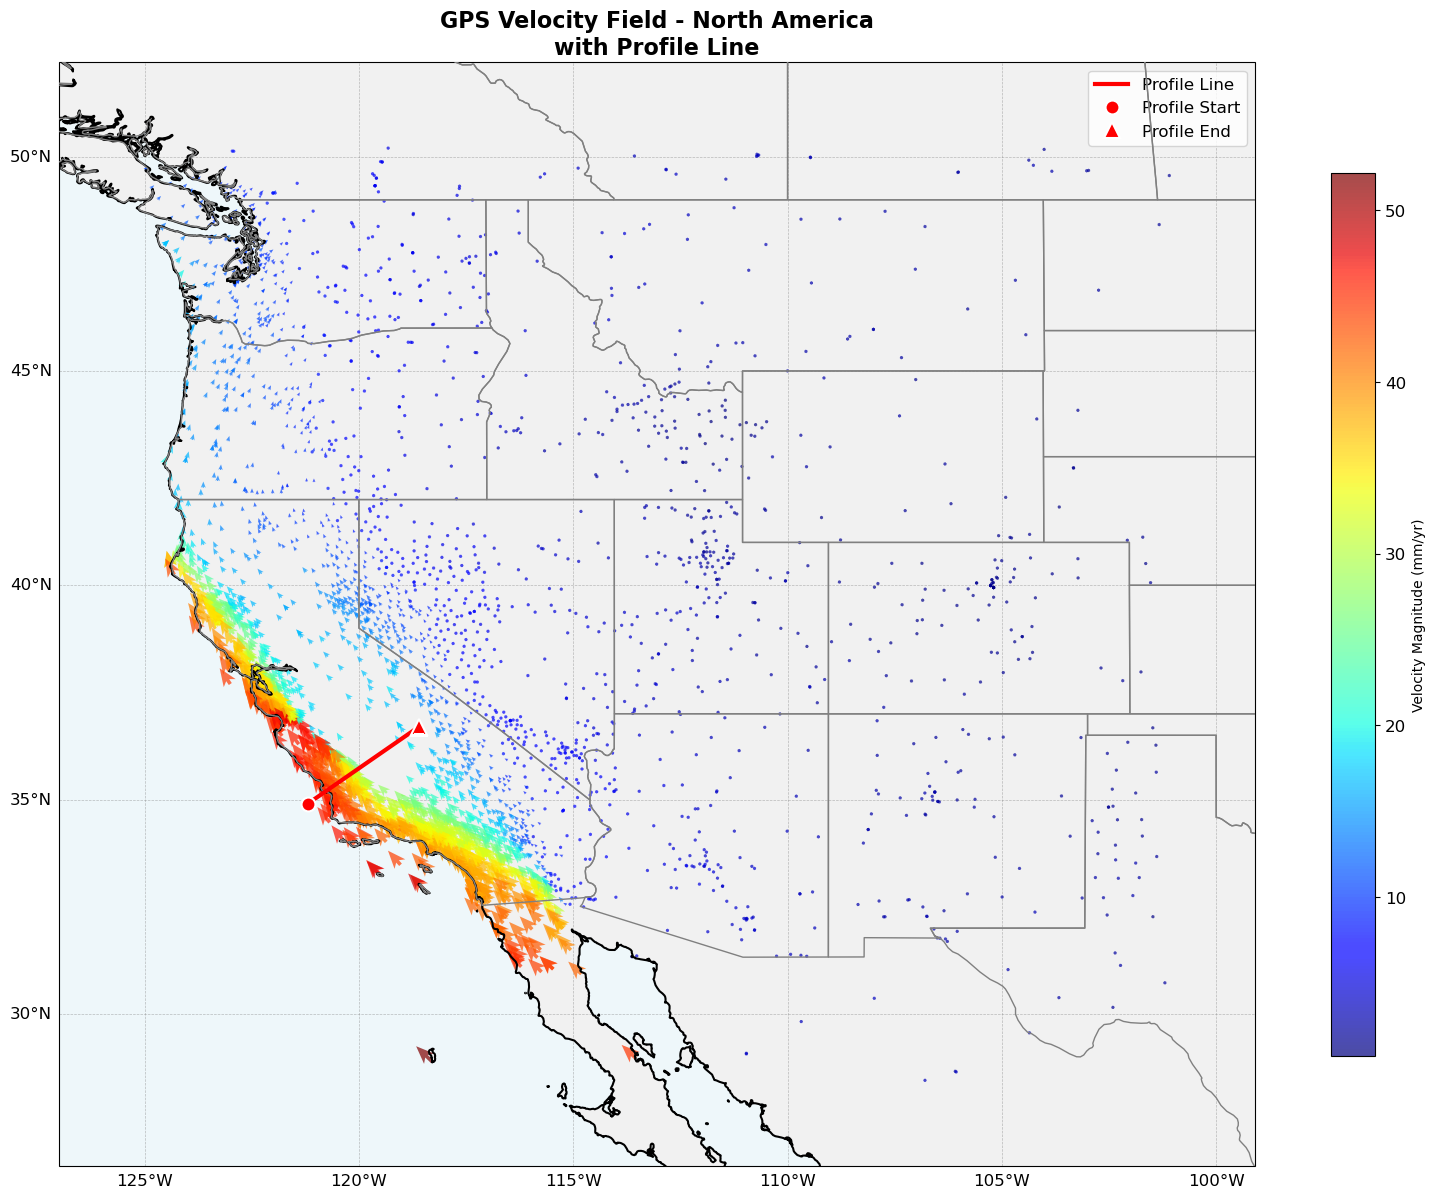


Zoomed region contains 857 GPS stations


/Users/kajjohns/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/kajjohns/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


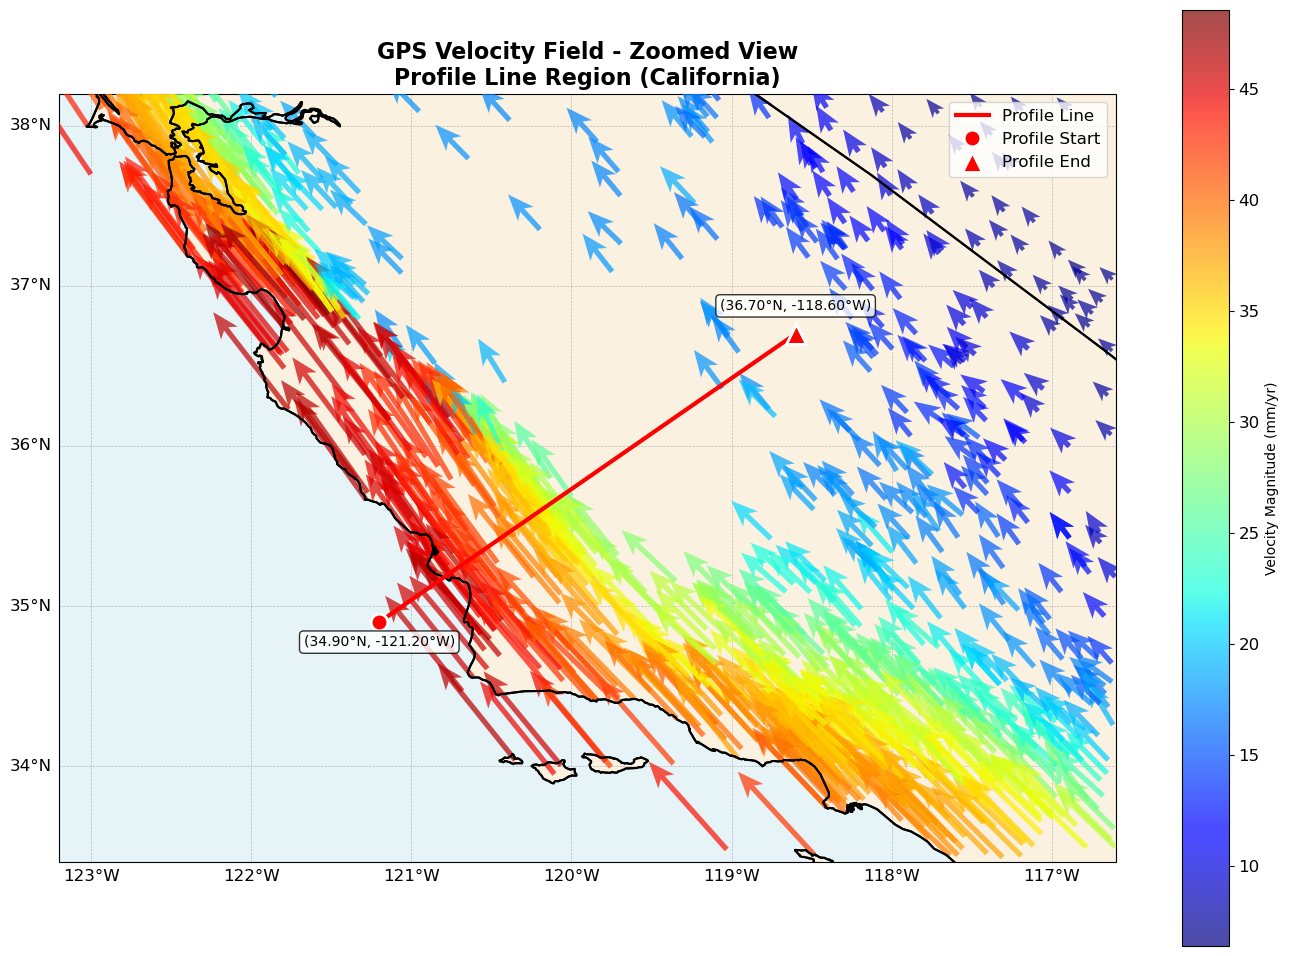

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Load GPS velocity data
# Columns: longitude, latitude, Ve, Vn, Se, Sn, C, Name
data = np.loadtxt('vel.NA.postseismic-corrected.txt', 
                  dtype={'names': ('lon', 'lat', 'Ve', 'Vn', 'Se', 'Sn', 'C', 'Name'),
                         'formats': ('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'U10')})

lon = data['lon']
lat = data['lat']
Ve = data['Ve']
Vn = data['Vn']
Se = data['Se']
Sn = data['Sn']

print(f"Loaded {len(data)} GPS stations")
print(f"Longitude range: [{lon.min():.2f}, {lon.max():.2f}]")
print(f"Latitude range: [{lat.min():.2f}, {lat.max():.2f}]")
print(f"Ve range: [{Ve.min():.2f}, {Ve.max():.2f}] mm/yr")
print(f"Vn range: [{Vn.min():.2f}, {Vn.max():.2f}] mm/yr")

# Profile line endpoints
profile_start = (34.9, -121.2)  # (lat, lon)
profile_end = (36.7, -118.6)

# Create figure with cartopy projection
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Plot GPS velocity vectors
velocity_magnitude = np.sqrt(Ve**2 + Vn**2)

# Create quiver plot for velocity vectors
quiver = ax.quiver(lon, lat, Ve, Vn, velocity_magnitude,
                   scale=100, scale_units='xy', 
                   cmap='jet', alpha=0.7, width=0.003,
                   headwidth=4, headlength=5, headaxislength=4,
                   transform=ccrs.PlateCarree(), zorder=5)

# Add colorbar for velocity magnitude
cbar = plt.colorbar(quiver, ax=ax, label='Velocity Magnitude (mm/yr)', shrink=0.8)
cbar.ax.tick_params(labelsize=12)

# Add map features
ax.coastlines(resolution='10m', linewidth=1.5, color='black', zorder=10)
ax.add_feature(cfeature.STATES, linewidth=1, edgecolor='gray', zorder=10)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3, zorder=1)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2, zorder=1)

# Plot profile line
ax.plot([profile_start[1], profile_end[1]], 
        [profile_start[0], profile_end[0]], 
        'r-', linewidth=3, label='Profile Line', zorder=15,
        transform=ccrs.PlateCarree())

# Add markers at profile endpoints
ax.plot(profile_start[1], profile_start[0], 'ro', markersize=10, 
        markeredgecolor='white', markeredgewidth=1.5, zorder=16, 
        label='Profile Start', transform=ccrs.PlateCarree())
ax.plot(profile_end[1], profile_end[0], 'r^', markersize=12, 
        markeredgecolor='white', markeredgewidth=1.5, zorder=16, 
        label='Profile End', transform=ccrs.PlateCarree())

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 12}
gl.ylabel_style = {'size': 12}

# Add labels and title
ax.set_xlabel('Longitude (°)', fontsize=14)
ax.set_ylabel('Latitude (°)', fontsize=14)
ax.set_title('GPS Velocity Field - North America\nwith Profile Line', fontsize=16, fontweight='bold')
ax.legend(fontsize=12, loc='upper right')

# Set extent to show all data
ax.set_extent([lon.min()-2, lon.max()+2, lat.min()-2, lat.max()+2], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

# Create a zoomed-in view around the profile line
fig2 = plt.figure(figsize=(14, 12))
ax2 = fig2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Define region around profile (add some buffer)
lon_buffer = 2.0
lat_buffer = 1.5
lon_min = min(profile_start[1], profile_end[1]) - lon_buffer
lon_max = max(profile_start[1], profile_end[1]) + lon_buffer
lat_min = min(profile_start[0], profile_end[0]) - lat_buffer
lat_max = max(profile_start[0], profile_end[0]) + lat_buffer

# Filter data for zoomed region
mask = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)
lon_zoom = lon[mask]
lat_zoom = lat[mask]
Ve_zoom = Ve[mask]
Vn_zoom = Vn[mask]
vel_mag_zoom = np.sqrt(Ve_zoom**2 + Vn_zoom**2)

print(f"\nZoomed region contains {np.sum(mask)} GPS stations")

# Plot zoomed velocity vectors
quiver2 = ax2.quiver(lon_zoom, lat_zoom, Ve_zoom, Vn_zoom, vel_mag_zoom,
                     scale=60, scale_units='xy', 
                     cmap='jet', alpha=0.7, width=0.005,
                     headwidth=4, headlength=5, headaxislength=4,
                     transform=ccrs.PlateCarree(), zorder=5)

cbar2 = plt.colorbar(quiver2, ax=ax2, label='Velocity Magnitude (mm/yr)', shrink=0.8)
cbar2.ax.tick_params(labelsize=12)

# Add map features
ax2.coastlines(resolution='10m', linewidth=1.5, color='black', zorder=10)
ax2.add_feature(cfeature.STATES, linewidth=1.5, edgecolor='black', zorder=10)
ax2.add_feature(cfeature.LAND, facecolor='wheat', alpha=0.4, zorder=1)
ax2.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3, zorder=1)

# Plot profile line
ax2.plot([profile_start[1], profile_end[1]], 
         [profile_start[0], profile_end[0]], 
         'r-', linewidth=3, label='Profile Line', zorder=15,
         transform=ccrs.PlateCarree())

# Add markers at profile endpoints
ax2.plot(profile_start[1], profile_start[0], 'ro', markersize=12, 
         markeredgecolor='white', markeredgewidth=2, zorder=16, 
         label='Profile Start', transform=ccrs.PlateCarree())
ax2.plot(profile_end[1], profile_end[0], 'r^', markersize=14, 
         markeredgecolor='white', markeredgewidth=2, zorder=16, 
         label='Profile End', transform=ccrs.PlateCarree())

# Add coordinate labels
ax2.text(profile_start[1], profile_start[0] - 0.15, 
         f'({profile_start[0]:.2f}°N, {profile_start[1]:.2f}°W)',
         fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         transform=ccrs.PlateCarree(), zorder=17)
ax2.text(profile_end[1], profile_end[0] + 0.15, 
         f'({profile_end[0]:.2f}°N, {profile_end[1]:.2f}°W)',
         fontsize=10, ha='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         transform=ccrs.PlateCarree(), zorder=17)

# Add gridlines
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabel_style = {'size': 12}
gl2.ylabel_style = {'size': 12}

ax2.set_xlabel('Longitude (°)', fontsize=14)
ax2.set_ylabel('Latitude (°)', fontsize=14)
ax2.set_title('GPS Velocity Field - Zoomed View\nProfile Line Region (California)', fontsize=16, fontweight='bold')
ax2.legend(fontsize=12, loc='upper right')
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

plt.tight_layout()
plt.show()

Local coordinate system origin: (35.8000°N, -119.9000°W)
Profile start in local coords: (-118.81 km, -99.06 km)
Profile end in local coords: (116.16 km, 100.63 km)

Found 72 GPS stations within 40 km of the profile line


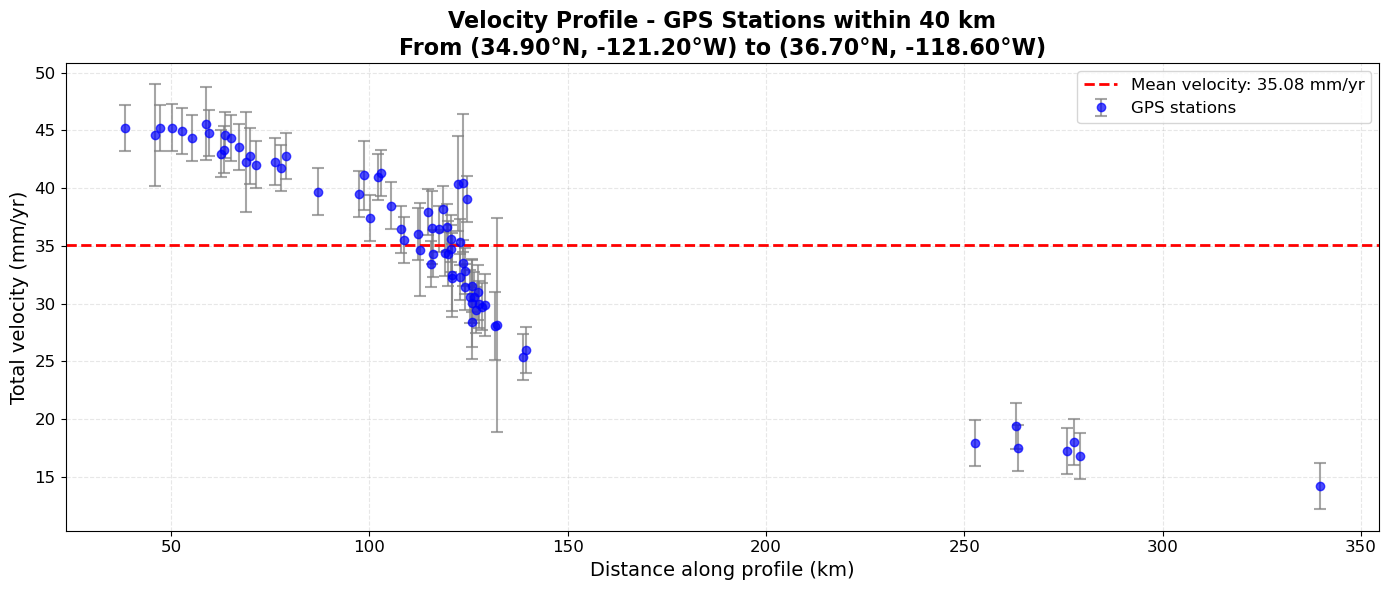


Profile Statistics:
Profile length: 308.36 km
Profile range in data: 38.46 to 339.60 km
Mean velocity: 35.08 ± 7.95 mm/yr
Velocity range: [14.18, 45.58] mm/yr
Mean uncertainty: 2.46 mm/yr


/Users/kajjohns/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/kajjohns/anaconda3/lib/python3.11/site-packages/shapely/predicates.py:878: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


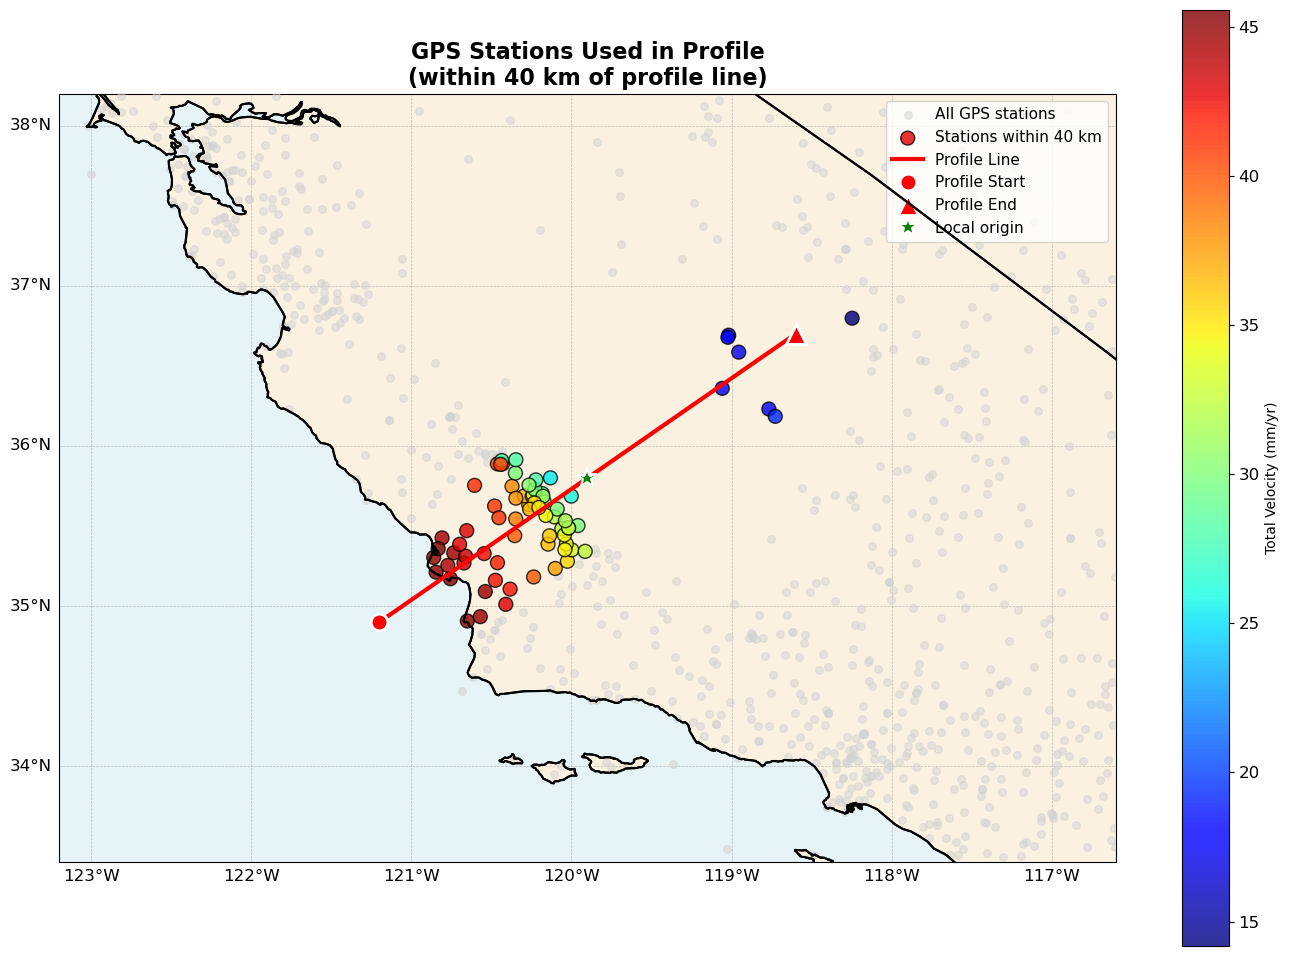

In [3]:
# Find GPS stations within 30 km of the profile line and create velocity profile
# Using pygeodesy LocalCartesian for accurate coordinate conversion

from pygeodesy.ltp import LocalCartesian

# Profile endpoints
prof_start_lat, prof_start_lon = profile_start
prof_end_lat, prof_end_lon = profile_end

# Set up local coordinate system with origin at the midpoint of the profile
mid_lat = (prof_start_lat + prof_end_lat) / 2
mid_lon = (prof_start_lon + prof_end_lon) / 2

# Create LocalCartesian converter
ltp = LocalCartesian(mid_lat, mid_lon, 0)  # lat, lon, height (height=0 for surface)

print(f"Local coordinate system origin: ({mid_lat:.4f}°N, {mid_lon:.4f}°W)")

# Convert profile endpoints to local x,y coordinates (in meters)
result1 = ltp.forward(prof_start_lat, prof_start_lon, 0)
result2 = ltp.forward(prof_end_lat, prof_end_lon, 0)
x1, y1, z1 = result1.x, result1.y, result1.z
x2, y2, z2 = result2.x, result2.y, result2.z

print(f"Profile start in local coords: ({x1/1000:.2f} km, {y1/1000:.2f} km)")
print(f"Profile end in local coords: ({x2/1000:.2f} km, {y2/1000:.2f} km)")

def distance_point_to_line_segment(px_m, py_m, x1_m, y1_m, x2_m, y2_m):
    """
    Calculate the perpendicular distance from point (px, py) to line segment from (x1, y1) to (x2, y2)
    Also returns the distance along the profile line
    All inputs in meters, returns distances in km
    """
    # Vector from start to end of line segment
    dx = x2_m - x1_m
    dy = y2_m - y1_m
    
    # Length of line segment
    length_squared = dx**2 + dy**2
    
    if length_squared == 0:
        # Start and end points are the same
        dist_perp = np.sqrt((px_m - x1_m)**2 + (py_m - y1_m)**2) / 1000.0
        dist_along = 0
        return dist_perp, dist_along
    
    # Parameter t: projection of point onto line (0 = start, 1 = end)
    t = ((px_m - x1_m) * dx + (py_m - y1_m) * dy) / length_squared
    
    # Distance along the profile (can be negative or > profile length)
    dist_along = t * np.sqrt(length_squared) / 1000.0  # convert to km
    
    # Clamp t to [0, 1] for perpendicular distance calculation
    t_clamped = np.clip(t, 0, 1)
    
    # Closest point on line segment
    closest_x = x1_m + t_clamped * dx
    closest_y = y1_m + t_clamped * dy
    
    # Perpendicular distance
    dist_perp = np.sqrt((px_m - closest_x)**2 + (py_m - closest_y)**2) / 1000.0  # convert to km
    
    return dist_perp, dist_along

# Calculate distances for all GPS stations
max_distance = 40  # km
distances_perp = []
distances_along = []
indices_near = []

# Convert all GPS stations to local coordinates
for i in range(len(lon)):
    # Convert lat/lon to local x,y (in meters)
    result = ltp.forward(lat[i], lon[i], 0)
    x, y, z = result.x, result.y, result.z
    
    # Calculate distances
    dist_perp, dist_along = distance_point_to_line_segment(
        x, y, x1, y1, x2, y2
    )
    
    if dist_perp <= max_distance:
        distances_perp.append(dist_perp)
        distances_along.append(dist_along)
        indices_near.append(i)

distances_perp = np.array(distances_perp)
distances_along = np.array(distances_along)
indices_near = np.array(indices_near)

print(f"\nFound {len(indices_near)} GPS stations within {max_distance} km of the profile line")

# Extract data for stations near the profile
lon_profile = lon[indices_near]
lat_profile = lat[indices_near]
Ve_profile = Ve[indices_near]
Vn_profile = Vn[indices_near]
Se_profile = Se[indices_near]
Sn_profile = Sn[indices_near]

# put floor of 2 mm/yr on uncertainties
Se_profile = np.maximum(Se_profile, 2.0)
Sn_profile = np.maximum(Sn_profile, 2.0)

# Calculate total velocity magnitude
V_total = np.sqrt(Ve_profile**2 + Vn_profile**2)

# Error propagation for total velocity: σ_V = sqrt((Ve*σe)^2 + (Vn*σn)^2) / V
# Derivation: V = sqrt(Ve^2 + Vn^2)
# dV/dVe = Ve/V, dV/dVn = Vn/V
# σ_V = sqrt((dV/dVe * σe)^2 + (dV/dVn * σn)^2)
S_total = np.sqrt((Ve_profile * Se_profile)**2 + (Vn_profile * Sn_profile)**2) / V_total

# Sort by distance along profile for plotting
sort_idx = np.argsort(distances_along)
distances_along_sorted = distances_along[sort_idx]
V_total_sorted = V_total[sort_idx]
S_total_sorted = S_total[sort_idx]

# Create profile plot
fig, ax = plt.subplots(figsize=(14, 6))

# Plot with error bars
ax.errorbar(distances_along_sorted, V_total_sorted, yerr=S_total_sorted, 
            fmt='o', markersize=6, capsize=4, capthick=1.5, 
            elinewidth=1.5, alpha=0.7, color='blue', 
            ecolor='gray', label='GPS stations')

# Add horizontal line at mean velocity
mean_velocity = np.mean(V_total_sorted)
ax.axhline(mean_velocity, color='red', linestyle='--', linewidth=2, 
           label=f'Mean velocity: {mean_velocity:.2f} mm/yr')

# Labels and formatting
ax.set_xlabel('Distance along profile (km)', fontsize=14)
ax.set_ylabel('Total velocity (mm/yr)', fontsize=14)
ax.set_title(f'Velocity Profile - GPS Stations within {max_distance} km\n' + 
             f'From ({prof_start_lat:.2f}°N, {prof_start_lon:.2f}°W) to ' +
             f'({prof_end_lat:.2f}°N, {prof_end_lon:.2f}°W)',
             fontsize=16, fontweight='bold')
ax.tick_params(labelsize=12)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=12, loc='best')

plt.tight_layout()
plt.show()

# Print statistics
profile_length = np.sqrt((x2-x1)**2 + (y2-y1)**2) / 1000.0  # km
print(f"\nProfile Statistics:")
print(f"Profile length: {profile_length:.2f} km")
print(f"Profile range in data: {distances_along_sorted[0]:.2f} to {distances_along_sorted[-1]:.2f} km")
print(f"Mean velocity: {mean_velocity:.2f} ± {np.std(V_total_sorted):.2f} mm/yr")
print(f"Velocity range: [{V_total_sorted.min():.2f}, {V_total_sorted.max():.2f}] mm/yr")
print(f"Mean uncertainty: {np.mean(S_total_sorted):.2f} mm/yr")

# Create a map showing selected stations with cartopy
fig2 = plt.figure(figsize=(14, 12))
ax2 = fig2.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Define region around profile
lon_buffer = 2.0
lat_buffer = 1.5
lon_min = min(prof_start_lon, prof_end_lon) - lon_buffer
lon_max = max(prof_start_lon, prof_end_lon) + lon_buffer
lat_min = min(prof_start_lat, prof_end_lat) - lat_buffer
lat_max = max(prof_start_lat, prof_end_lat) + lat_buffer

# Filter data for zoomed region
mask_zoom = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)

# Add map features
ax2.coastlines(resolution='10m', linewidth=1.5, color='black', zorder=10)
ax2.add_feature(cfeature.STATES, linewidth=1.5, edgecolor='black', zorder=10)
ax2.add_feature(cfeature.LAND, facecolor='wheat', alpha=0.4, zorder=1)
ax2.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.3, zorder=1)

# Plot all stations in region (gray)
ax2.scatter(lon[mask_zoom], lat[mask_zoom], c='lightgray', s=30, alpha=0.5, 
            label='All GPS stations', zorder=3, transform=ccrs.PlateCarree())

# Highlight stations used in profile (colored by velocity)
scatter = ax2.scatter(lon_profile, lat_profile, c=V_total, s=100, 
                     cmap='jet', alpha=0.8, edgecolors='black', linewidth=1,
                     label=f'Stations within {max_distance} km', zorder=5,
                     transform=ccrs.PlateCarree())

cbar = plt.colorbar(scatter, ax=ax2, label='Total Velocity (mm/yr)', shrink=0.8)
cbar.ax.tick_params(labelsize=12)

# Plot profile line
ax2.plot([prof_start_lon, prof_end_lon], 
         [prof_start_lat, prof_end_lat], 
         'r-', linewidth=3, label='Profile Line', zorder=15,
         transform=ccrs.PlateCarree())

# Add markers at profile endpoints
ax2.plot(prof_start_lon, prof_start_lat, 'ro', markersize=12, 
         markeredgecolor='white', markeredgewidth=2, zorder=16, label='Profile Start',
         transform=ccrs.PlateCarree())
ax2.plot(prof_end_lon, prof_end_lat, 'r^', markersize=14, 
         markeredgecolor='white', markeredgewidth=2, zorder=16, label='Profile End',
         transform=ccrs.PlateCarree())

# Add marker for local coordinate origin
ax2.plot(mid_lon, mid_lat, 'g*', markersize=15, 
         markeredgecolor='white', markeredgewidth=1.5, zorder=16, label='Local origin',
         transform=ccrs.PlateCarree())

# Add gridlines
gl2 = ax2.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False
gl2.xlabel_style = {'size': 12}
gl2.ylabel_style = {'size': 12}

ax2.set_xlabel('Longitude (°)', fontsize=14)
ax2.set_ylabel('Latitude (°)', fontsize=14)
ax2.set_title(f'GPS Stations Used in Profile\n(within {max_distance} km of profile line)', 
              fontsize=16, fontweight='bold')
ax2.legend(fontsize=11, loc='upper right')
ax2.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax2.legend(fontsize=11, loc='upper right')
ax2.set_xlim(lon_min, lon_max)
ax2.set_ylim(lat_min, lat_max)
ax2.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [4]:
def fault_velocity_model(x, s, xf, d, shift):
    """
    Calculate surface velocity due to a locked fault at depth.
    
    This model represents the velocity field at the surface due to a vertical
    strike-slip fault that is locked from the surface to depth d, with slip
    rate s occurring below the locking depth.
    
    Parameters:
    -----------
    x : float or array-like
        Position(s) along the profile where velocity is calculated (km)
    s : float
        Slip rate on the fault (mm/yr)
    xf : float
        Position of the fault along the profile (km)
    d : float
        Locking depth of the fault (km)
    
    Returns:
    --------
    v : float or array-like
        Velocity at position(s) x (mm/yr)
        
    Notes:
    ------
    The arctangent model assumes:
    - Vertical fault
    - Elastic half-space
    - Fault is locked from surface to depth d
    - Constant slip rate s below locking depth
    - 2D (plane strain) geometry
    """
    v = -s / np.pi * np.arctan((x - xf) / d) + shift
    return v



In [14]:
## Conduct MCMC fitting to estimate fault parameters
#NOTE:  data arrays distances_along_sorted, V_total_sorted, S_total_sorted

#rename arrays
xobs = distances_along_sorted
d = V_total_sorted
sigma = S_total_sorted

# Metropolis acceptance function
def metropolis(g1, g2):
    """
    Metropolis acceptance criterion
    g1: log probability of current sample
    g2: log probability of proposed sample
    """
    rat = np.exp(g2 - g1)
    if rat > 1:
        accept = 1
    else:
        r = np.random.rand()
        if r < rat:
            accept = 1
        else:
            accept = 0
    return accept




# Initial guess
s = 30  # slip rate (mm/yr)
xf = 120   # fault position (km)
Ld = 15   # locking depth (km)
shift = 30  # vertical shift (mm/yr) 

# Calculate initial model prediction
X = np.array([s, xf, Ld, shift])  # model parameters array

# Number of MC samples
NumSamples = int(1e5)
# Step sizes for Metropolis random walk (width of uniform proposal distribution)
stepsize = np.array([2, 1, 2, 1])  # adjust as needed

# Begin Monte Carlo Metropolis walk
M = np.zeros((len(X), NumSamples))  # store up samples
logprobs = np.zeros(NumSamples)
dhats = np.zeros((len(d), NumSamples))  # store up all dhat

accept_sample = 0  # keep track of acceptance rate

for k in range(NumSamples):
    # Take a random step in model space to select trial value
    r = (-1)**np.round(np.random.rand(len(X))) * np.random.rand(len(X))  # rand (-1,1)
    r = r * stepsize
    X = X + r  # trial value (X prime)
    
    s = X[0]
    xf = X[1]
    Ld = X[2]
    shift = X[3]
    dhat2 = fault_velocity_model(xobs, s, xf, Ld, shift)
    resid = (d - dhat2) / sigma  # weighted residual vector
    
    #include a gaussian prior on locking depth
    prior_mean = 15
    prior_std = 5
    prior = -0.5 * ((Ld - prior_mean) / prior_std) ** 2

    # Compute log probability of trial sample
    logprob2 = -0.5 * np.dot(resid, resid) + prior  # assumes Gaussian likelihood
    
   

    # Use Metropolis rule to decide whether or not to accept model
    if k == 0:
        logprob = logprob2
        dhat = dhat2
    
    accept = metropolis(logprob, logprob2)
    
    if accept == 1:  # if accept==1, keep the model
        logprob = logprob2
        dhat = dhat2
        Xprev = X.copy()
        logprobprev = logprob
        accept_sample = accept_sample + 1
    else:  # if accept==0, discard this model and retain previous
        X = Xprev.copy()
        logprob = logprobprev
    
    # Store results matrices
    M[:, k] = X
    
    # Store values
    logprobs[k] = logprob
    dhats[:, k] = dhat

acceptance_rate = accept_sample / NumSamples
print(f'Acceptance rate: {acceptance_rate:.4f}')


Acceptance rate: 0.2664


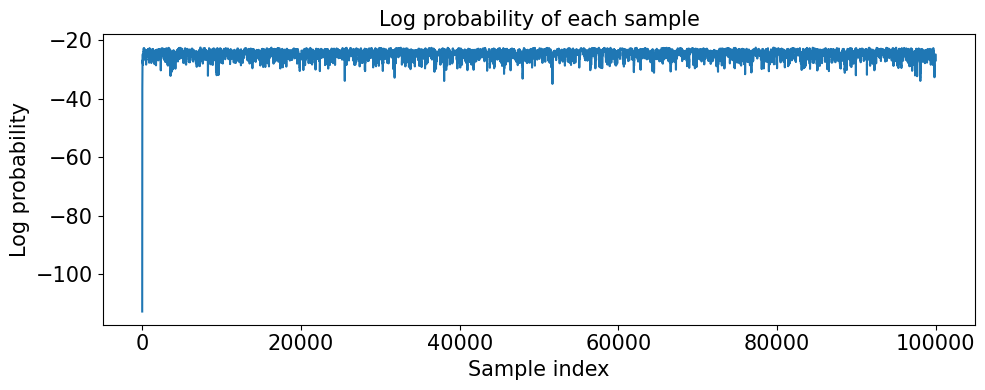

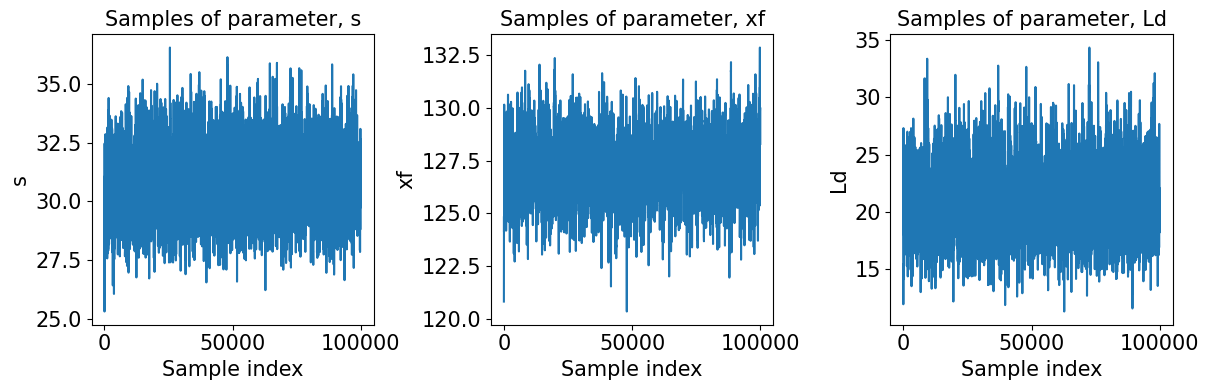

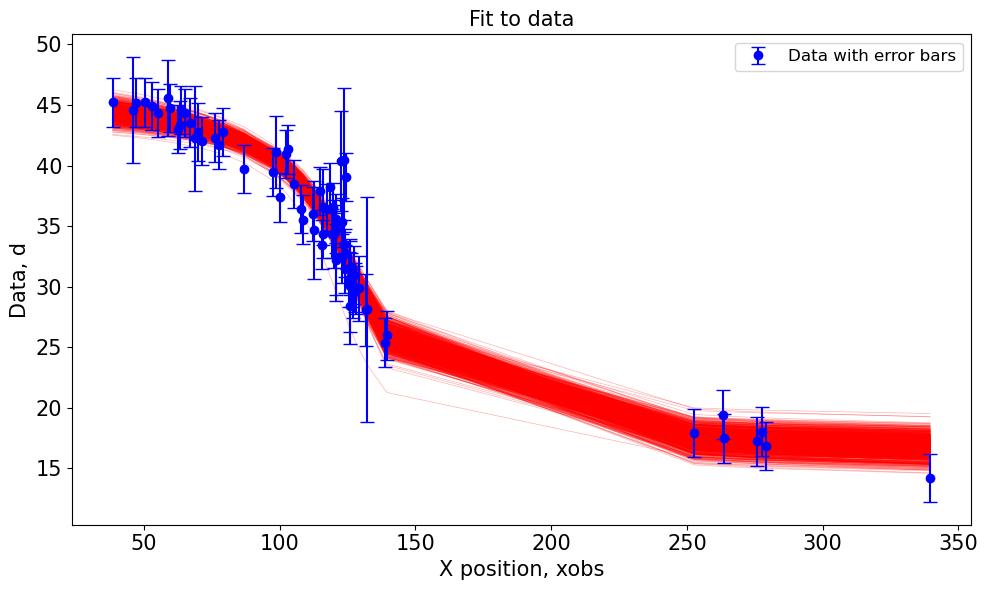

In [12]:

# Evaluate quality of sampling
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(logprobs)
ax.set_title('Log probability of each sample', fontsize=15)
ax.tick_params(labelsize=15)
ax.set_xlabel('Sample index', fontsize=15)
ax.set_ylabel('Log probability', fontsize=15)
plt.tight_layout()
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.plot(M[0, :])
ax1.set_title('Samples of parameter, s', fontsize=15)
ax1.tick_params(labelsize=15)
ax1.set_xlabel('Sample index', fontsize=15)
ax1.set_ylabel('s', fontsize=15)

ax2.plot(M[1, :])
ax2.set_title('Samples of parameter, xf', fontsize=15)
ax2.tick_params(labelsize=15)
ax2.set_xlabel('Sample index', fontsize=15)
ax2.set_ylabel('xf', fontsize=15)


ax3.plot(M[2, :])
ax3.set_title('Samples of parameter, Ld', fontsize=15)
ax3.tick_params(labelsize=15)
ax3.set_xlabel('Sample index', fontsize=15)
ax3.set_ylabel('Ld', fontsize=15)
plt.tight_layout()
plt.show()

# Plot fit to data
fig, ax = plt.subplots(figsize=(10, 6))
# Plot subset of fits (every 100th sample)
ax.plot(xobs, dhats[:, ::100], 'r', alpha=0.3, linewidth=0.5)
ax.errorbar(xobs, d, yerr=sigma, fmt='bo', capsize=5, label='Data with error bars')
ax.tick_params(labelsize=15)
ax.set_title('Fit to data', fontsize=15)
ax.set_xlabel('X position, xobs', fontsize=15)
ax.set_ylabel('Data, d', fontsize=15)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

Parameter Estimates (mean ± std):
Slip rate (s):        30.83 ± 1.40 mm/yr
Fault position (xf):  127.09 ± 1.45 km
Locking depth (Ld):   20.97 ± 3.02 km
Velocity shift:       31.23 ± 0.49 mm/yr


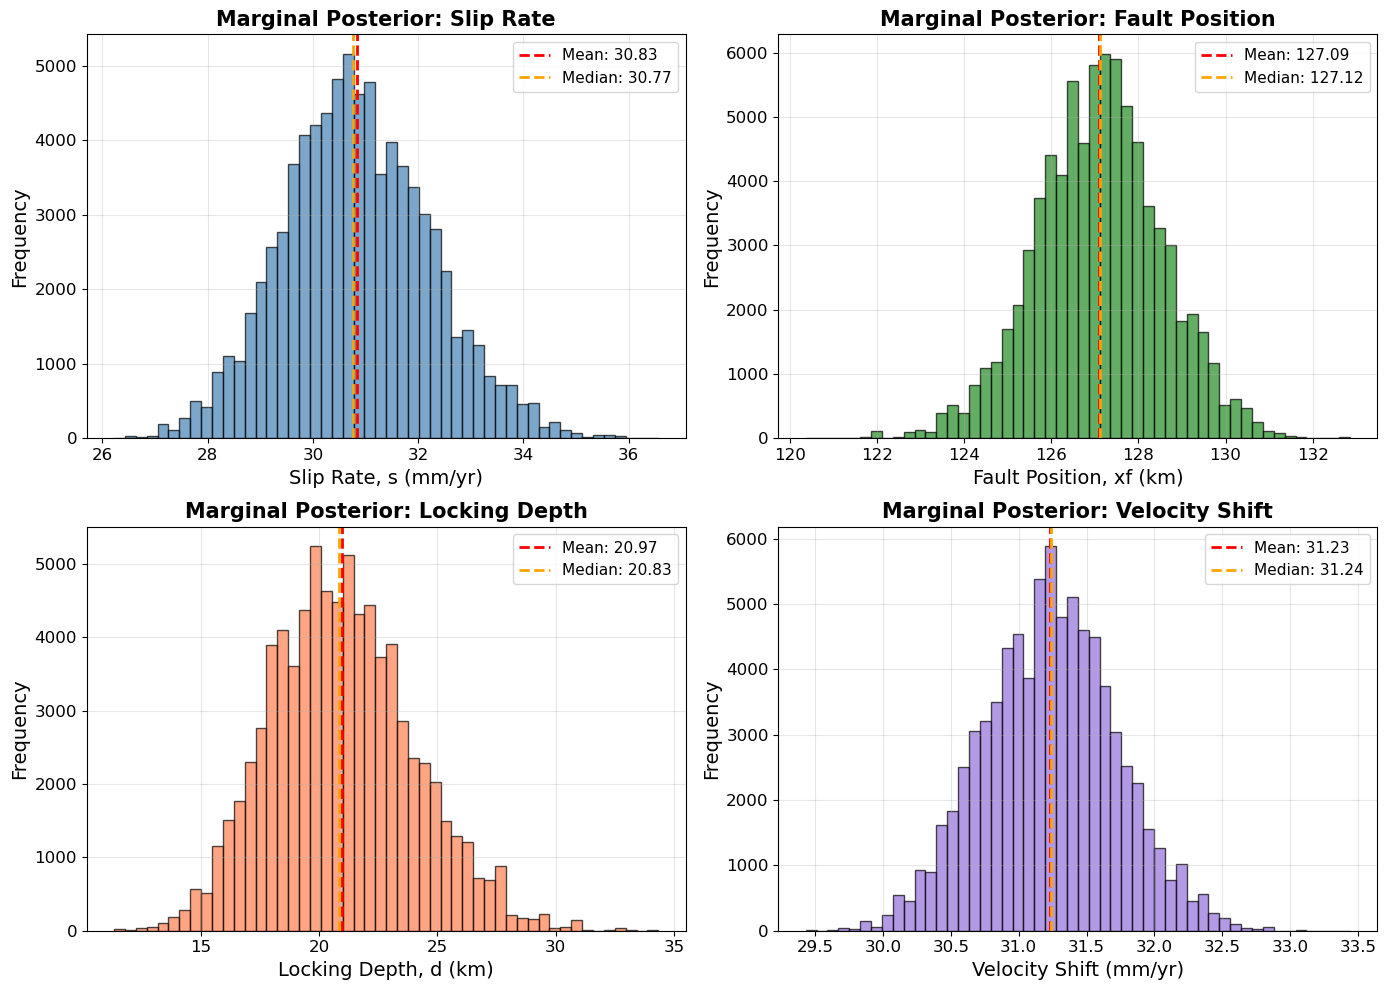

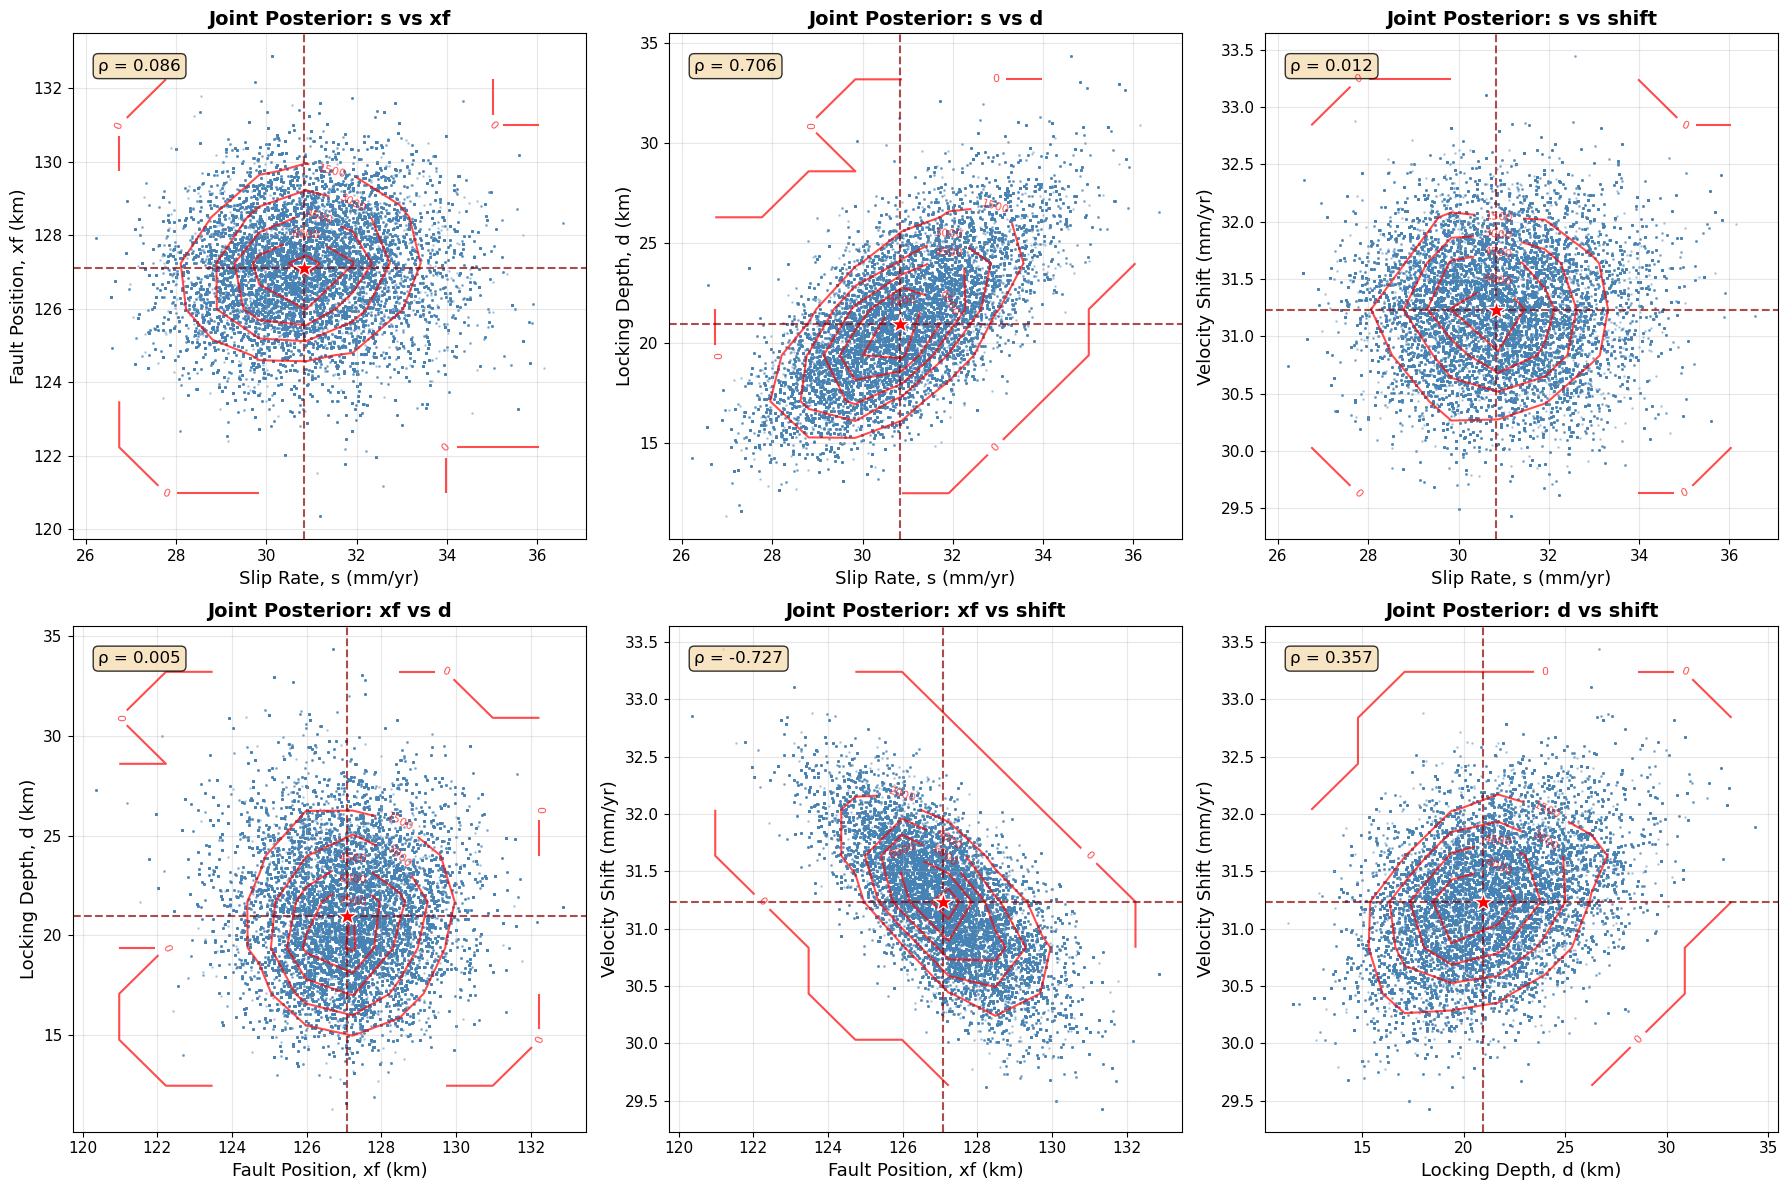


Correlation Matrix:


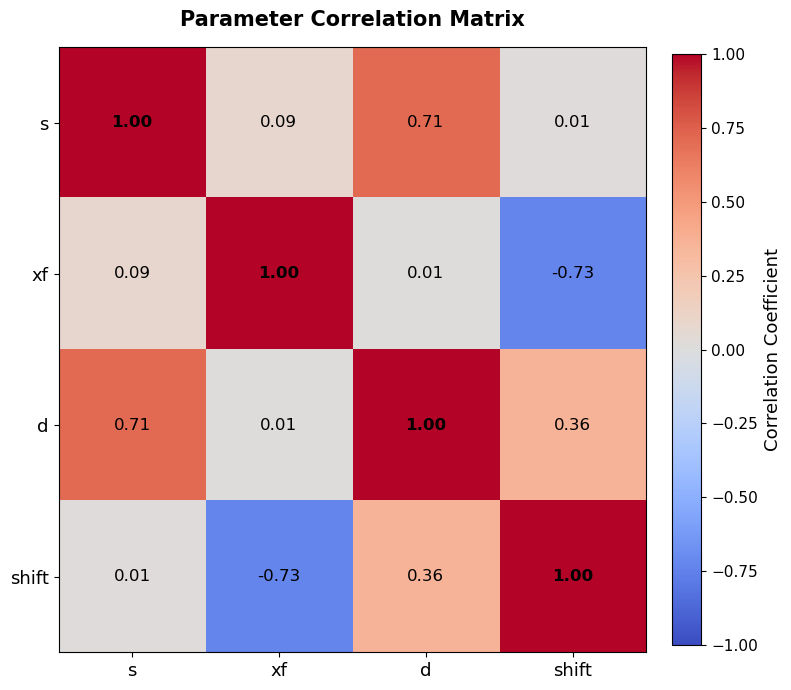


Correlation coefficients:
  s vs xf: 0.086
  s vs d: 0.706
  s vs shift: 0.012
  xf vs d: 0.005
  xf vs shift: -0.727
  d vs shift: 0.357


In [13]:
# Marginal Posterior Distributions and Parameter Correlations

# Discard burn-in period (first 20% of samples)
burn_in = int(0.2 * NumSamples)
M_burned = M[:, burn_in:]

# Extract parameter samples after burn-in
s_samples = M_burned[0, :]
xf_samples = M_burned[1, :]
Ld_samples = M_burned[2, :]
shift_samples = M_burned[3, :]

# Calculate statistics
print("Parameter Estimates (mean ± std):")
print(f"Slip rate (s):        {np.mean(s_samples):.2f} ± {np.std(s_samples):.2f} mm/yr")
print(f"Fault position (xf):  {np.mean(xf_samples):.2f} ± {np.std(xf_samples):.2f} km")
print(f"Locking depth (Ld):   {np.mean(Ld_samples):.2f} ± {np.std(Ld_samples):.2f} km")
print(f"Velocity shift:       {np.mean(shift_samples):.2f} ± {np.std(shift_samples):.2f} mm/yr")

# 1. MARGINAL DISTRIBUTIONS (Histograms)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Slip rate
ax = axes[0, 0]
counts, bins, patches = ax.hist(s_samples, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(np.mean(s_samples), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(s_samples):.2f}')
ax.axvline(np.median(s_samples), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(s_samples):.2f}')
ax.set_xlabel('Slip Rate, s (mm/yr)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Marginal Posterior: Slip Rate', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=12)

# Fault position
ax = axes[0, 1]
counts, bins, patches = ax.hist(xf_samples, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
ax.axvline(np.mean(xf_samples), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(xf_samples):.2f}')
ax.axvline(np.median(xf_samples), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(xf_samples):.2f}')
ax.set_xlabel('Fault Position, xf (km)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Marginal Posterior: Fault Position', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=12)

# Locking depth
ax = axes[1, 0]
counts, bins, patches = ax.hist(Ld_samples, bins=50, edgecolor='black', alpha=0.7, color='coral')
ax.axvline(np.mean(Ld_samples), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(Ld_samples):.2f}')
ax.axvline(np.median(Ld_samples), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(Ld_samples):.2f}')
ax.set_xlabel('Locking Depth, d (km)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Marginal Posterior: Locking Depth', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=12)

# Velocity shift
ax = axes[1, 1]
counts, bins, patches = ax.hist(shift_samples, bins=50, edgecolor='black', alpha=0.7, color='mediumpurple')
ax.axvline(np.mean(shift_samples), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(shift_samples):.2f}')
ax.axvline(np.median(shift_samples), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(shift_samples):.2f}')
ax.set_xlabel('Velocity Shift (mm/yr)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Marginal Posterior: Velocity Shift', fontsize=15, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

# 2. JOINT POSTERIOR DISTRIBUTIONS (Scatter plots with contours)
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Function to plot 2D histogram with contours
def plot_joint_distribution(ax, x_data, y_data, x_label, y_label, title):
    # Scatter plot
    ax.scatter(x_data, y_data, alpha=0.3, s=1, c='steelblue', rasterized=True)
    
    # Calculate 2D histogram for contours
    H, xedges, yedges = np.histogram2d(x_data, y_data, bins=10)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot contours
    X, Y = np.meshgrid((xedges[:-1] + xedges[1:]) / 2, (yedges[:-1] + yedges[1:]) / 2)
    contours = ax.contour(X, Y, H.T, levels=5, colors='red', linewidths=1.5, alpha=0.7)
    ax.clabel(contours, inline=True, fontsize=8)
    
    # Add mean values
    ax.axvline(np.mean(x_data), color='darkred', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.axhline(np.mean(y_data), color='darkred', linestyle='--', linewidth=1.5, alpha=0.7)
    ax.plot(np.mean(x_data), np.mean(y_data), 'r*', markersize=15, 
            markeredgecolor='white', markeredgewidth=1)
    
    ax.set_xlabel(x_label, fontsize=13)
    ax.set_ylabel(y_label, fontsize=13)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.tick_params(labelsize=11)
    
    # Calculate correlation coefficient
    corr = np.corrcoef(x_data, y_data)[0, 1]
    ax.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax.transAxes, 
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# s vs xf
plot_joint_distribution(axes[0, 0], s_samples, xf_samples, 
                       'Slip Rate, s (mm/yr)', 'Fault Position, xf (km)',
                       'Joint Posterior: s vs xf')

# s vs Ld
plot_joint_distribution(axes[0, 1], s_samples, Ld_samples, 
                       'Slip Rate, s (mm/yr)', 'Locking Depth, d (km)',
                       'Joint Posterior: s vs d')

# s vs shift
plot_joint_distribution(axes[0, 2], s_samples, shift_samples, 
                       'Slip Rate, s (mm/yr)', 'Velocity Shift (mm/yr)',
                       'Joint Posterior: s vs shift')

# xf vs Ld
plot_joint_distribution(axes[1, 0], xf_samples, Ld_samples, 
                       'Fault Position, xf (km)', 'Locking Depth, d (km)',
                       'Joint Posterior: xf vs d')

# xf vs shift
plot_joint_distribution(axes[1, 1], xf_samples, shift_samples, 
                       'Fault Position, xf (km)', 'Velocity Shift (mm/yr)',
                       'Joint Posterior: xf vs shift')

# Ld vs shift
plot_joint_distribution(axes[1, 2], Ld_samples, shift_samples, 
                       'Locking Depth, d (km)', 'Velocity Shift (mm/yr)',
                       'Joint Posterior: d vs shift')

plt.tight_layout()
plt.show()

# 3. CORRELATION MATRIX
print("\nCorrelation Matrix:")
param_names = ['s', 'xf', 'd', 'shift']
corr_matrix = np.corrcoef(M_burned)

fig, ax = plt.subplots(figsize=(8, 7))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Correlation Coefficient', fontsize=13)
cbar.ax.tick_params(labelsize=11)

# Set ticks and labels
ax.set_xticks(np.arange(len(param_names)))
ax.set_yticks(np.arange(len(param_names)))
ax.set_xticklabels(param_names, fontsize=13)
ax.set_yticklabels(param_names, fontsize=13)

# Add text annotations
for i in range(len(param_names)):
    for j in range(len(param_names)):
        text = ax.text(j, i, f'{corr_matrix[i, j]:.2f}',
                      ha="center", va="center", color="black", fontsize=12,
                      fontweight='bold' if i == j else 'normal')

ax.set_title('Parameter Correlation Matrix', fontsize=15, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

print("\nCorrelation coefficients:")
for i in range(len(param_names)):
    for j in range(i+1, len(param_names)):
        print(f"  {param_names[i]} vs {param_names[j]}: {corr_matrix[i, j]:.3f}")